# Image Classification: Sign-Language-MNIST

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 30 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 9s (48.6 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+c

In [2]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [3]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 224MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 165MB/s]


In [4]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [5]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

 ## Parsing the dataset

In [43]:
def parse_data_from_input(filename):
  
  with open(filename) as file:
    
    csv_reader = csv.reader(file, delimiter=',')
    
    labels = []
    images = []

    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        line_count = 1
      else:
        labels.append(row[0])
        images.append(np.reshape(row[1:], (28, 28)))

    labels = np.array(labels, dtype = np.float64)
    images = np.array(images, dtype = np.float64)

    return images, labels

In [44]:
# Test function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

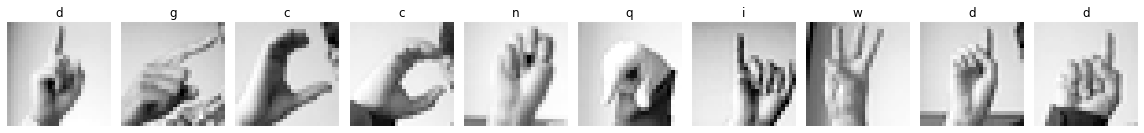

In [45]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

In [54]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  
  training_images = np.expand_dims(training_images, axis = 3)
  validation_images = np.expand_dims(validation_images, axis = 3)

  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=40, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2, 
                                     shear_range=0.2, 
                                     zoom_range=0.2, 
                                     horizontal_flip=True, 
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  return train_generator, validation_generator

In [55]:
# Test generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [86]:
def create_model():     

  # Define the model
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    ])

  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])      
  
  return model

In [87]:
# Save model
model = create_model()

# Train model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 11s 12ms/step - loss: 2.5325 - accuracy: 0.2296 - val_loss: 1.4492 - val_accuracy: 0.5059
Epoch 2/15
858/858 [==============================] - 11s 12ms/step - loss: 1.6496 - accuracy: 0.4684 - val_loss: 0.8003 - val_accuracy: 0.7368
Epoch 3/15
858/858 [==============================] - 10s 12ms/step - loss: 1.2180 - accuracy: 0.6052 - val_loss: 0.5416 - val_accuracy: 0.8101
Epoch 4/15
858/858 [==============================] - 10s 12ms/step - loss: 0.9635 - accuracy: 0.6819 - val_loss: 0.3747 - val_accuracy: 0.8833
Epoch 5/15
858/858 [==============================] - 11s 13ms/step - loss: 0.8019 - accuracy: 0.7360 - val_loss: 0.3353 - val_accuracy: 0.8956
Epoch 6/15
858/858 [==============================] - 10s 12ms/step - loss: 0.7116 - accuracy: 0.7648 - val_loss: 0.2159 - val_accuracy: 0.9357
Epoch 7/15
858/858 [==============================] - 10s 12ms/step - loss: 0.6126 - accuracy: 0.7959 - val_loss: 0.1925 - val_accuracy:

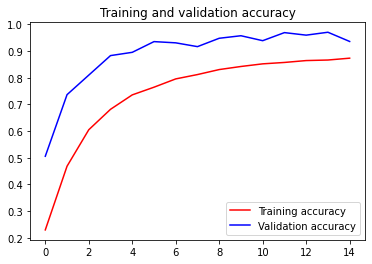

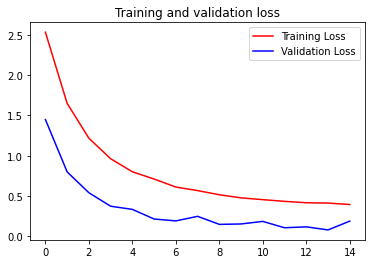

In [88]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()